In [44]:
#####  SIMPLE EUROPEAN SOCCER GAME PREDICTOR #####
## This is a simple random forest predictor trained on match dataset from Kaggle Europen Soccer Database.
## This code is a good starting point on which you can easily build your own solution.
##
##DATA:
##   The match data is composed of three types of variables:
##   1. The variables that identify the match like the teams, stage(arena), date ..etc.
##   2. The betting odds\coeficients that come from bookkepers\betting sites like bet&win 
##      ('BWH' for home team winning odds, 'BWD' for odds of a draw  and 'BWA' for away team's odds of winning..)
##   3. The players ids (11 for each team)
##
##CONCLUSION:
##  After a couple of test runs, I found the following to be true about match dataset and RF:
##  The features that contribute the most to the accuracy (in order) are: 
##          home team, away team, stage\arena, betting odds and month (no surprises)
##  Features like year, season, country and most players do not help.
##  This simple classifier reaches an accuracy of 0.52 if all variables are used.
##  Even when we use a very small subset (like 2 bookkepers and 3 players), the accuracy is compareable ~ 0.51.
##  Using column means in place of NaNs did not help for bookkeper variables.
##
##COMPARISON:
##  I will compare this notebook to one by harvinderwazir(Airback) at 
##  https://www.kaggle.com/harvinderwazir/d/hugomathien/soccer/match-outcome-prediction-in-football
##  Airback's top accuracy is 0.55, it is based on PCA combination of multiple known methods like GaussianNB. 
##  Airback's time complexity is high, meaning that its training time is huge, 
##  so it was not run on the full dataset but rather on a subset of the match dataset.
##  Airback utilizes all available features and it does not predict draws.
##  Unlike Airback's, my random forest based solution is plain and simple. 
##  It runs on the full dataset without problems and hit a top accuracy of 0.52 after tweaking some parameters.
##  My laptop(with A8 processor) cruched it in 3 minutes. 
##  It reaches 0.51 accuracy with minimal features and unlike Airback, it can predict draws.
##
##DISCUSSION:
##1. I don't understand the use of features like corners and cards. This information can not be used 
##   as arguments to the prediction function since these events occur during the match. 
##   They may be subjected to time series analysis but this seems a far fetched relationship. 
##   Is there any solution that uses these features effectively?
##2. This data can be used to create a feature to quantify the success trend of teams which may improve the accuracy.
##   Such a feature could be the rate of past 5 match performance over the earlier ones.
##   My attempt to create such a feature can be reached in my other post for this dataset.
##3. All feedback\comments wellcome.
##
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import sample
import sklearn.ensemble as sk
import sklearn.metrics as skm
import pylab as pl
import warnings
warnings.filterwarnings('ignore')
path = "C:\\temp\\soccer\\"  
database = path + 'database.sqlite'
conn = sqlite3.connect(database)
match = pd.read_sql("SELECT * FROM Match;", conn)
m2 = pd.read_sql("SELECT away_player_X7,count(*) FROM Match GROUP BY away_player_X7;", conn)


In [45]:
selected_cols=['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 
                'date',  'country_id', 'league_id', 'season', 'stage']  
match.dropna(subset = selected_cols, inplace = True) #should not have NaNs in these columns

In [46]:
# select a random subset of matches if you like to run on a short dataset (match dataframe has 26000 observations)
#mm=match.loc[np.random.permutation(match.index)[:1000]]

In [47]:
# Use only these columns to build the RF based predicton model
selected_cols=['home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'date', 
 'country_id',
 'league_id',
 'season',
 'stage',               
 'B365H',  'BWH',  #'IWH',  'LBH', 'PSH',  'WHH',  'SJH',  'VCH',  'GBH',  'BSH',  # betting coefficients\odds
 'B365D',  'BWD',  #'IWD',  'LBD', 'PSD',  'WHD',  'SJD',  'VCD',  'GBD',  'BSD',  
 'B365A',  'BWA',  #'IWA',  'LBA', 'PSA',  'WHA',  'SJA',  'VCA',  'GBA',  'BSA',
 'home_player_7',
 'away_player_7',
 'home_player_10',
 'home_player_11',
 'away_player_10',
 'away_player_11'
              ]

#Inevitable data cleaning
mm2=match[selected_cols]
mm2['BWH'].fillna(mm2['BWH'].mean(),inplace=True)
mm2['BWA'].fillna(mm2['BWA'].mean(),inplace=True)
mm2['BWD'].fillna(mm2['BWD'].mean(),inplace=True)
mm2['B365H'].fillna(mm2['B365H'].mean(),inplace=True)
mm2['B365A'].fillna(mm2['B365A'].mean(),inplace=True)
mm2['B365D'].fillna(mm2['B365D'].mean(),inplace=True)
mm2.fillna(0,inplace=True)

# Add year and month columns , but they won't help much
mm2['date'] = pd.to_datetime(mm2['date'])
mm2 = mm2.assign(month=mm2['date'].dt.month)
mm2['date'] = mm2['date'].dt.year
mm2['season']= mm2['season'].str[:4]

In [48]:
mm=mm2

In [49]:
def train_validate_test_split(df, train_percent=.7, validate_percent=.15, seed=None):
        # From stackoverflow.com
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

np.random.seed([3,4195])
train, validate, test = train_validate_test_split(mm)

In [50]:
def result(a,b):
  if (a>b) : return "Win"
  if (a<b) : return "Loss"
  return "Draw"
# True classes for training, validation and test sets
class_test=test.apply(lambda row: result(row['home_team_goal'], row['away_team_goal']), axis=1)
class_validate=validate.apply(lambda row: result(row['home_team_goal'], row['away_team_goal']), axis=1)
class_train=train.apply(lambda row: result(row['home_team_goal'], row['away_team_goal']), axis=1)
#delete goals from data otherwise it is going to be real easy to predict!
del test['home_team_goal']
del test['away_team_goal']
del train['home_team_goal']
del train['away_team_goal']
del validate['home_team_goal']
del validate['away_team_goal']


In [51]:
class_validate.value_counts()

Win     1758
Loss    1173
Draw     965
dtype: int64

In [52]:
rfc = sk.RandomForestClassifier(n_estimators=400, oob_score=True, min_samples_leaf=1)
model = rfc.fit(train, class_train)

In [53]:
rfc.oob_score_

0.50332691778938687

In [54]:
validate_predictions = rfc.predict(validate)
print("mean accuracy score for validation set = %f" %(rfc.score(validate, class_validate)))

mean accuracy score for validation set = 0.518994


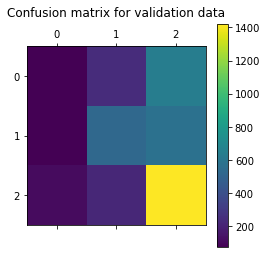

In [55]:
test_cm = skm.confusion_matrix(class_validate,validate_predictions)
pl.matshow(test_cm)
pl.title('Confusion matrix for validation data\n'
         + '                               ')
pl.colorbar()
pl.show()

In [56]:
# Confusion Matrix
test_cm

array([[  75,  244,  646],
       [  73,  527,  573],
       [ 113,  225, 1420]])

In [57]:
#Feature Importance rank
fi = enumerate(rfc.feature_importances_)
cols = train.columns
fi=[(value,cols[i]) for (i,value) in fi if value > 0.005]
fi.sort(key=lambda tup: tup[0], reverse=True) 
fi

[(0.066607309557216707, 'away_player_7'),
 (0.065983021379441481, 'home_player_7'),
 (0.065483957580483851, 'away_player_10'),
 (0.065177556290075808, 'home_player_10'),
 (0.064385756249192169, 'home_player_11'),
 (0.063434804541350726, 'away_player_11'),
 (0.063353164057094291, 'home_team_api_id'),
 (0.062856329340168063, 'away_team_api_id'),
 (0.059726004219773629, 'stage'),
 (0.055320472644432767, 'BWA'),
 (0.054134104195175003, 'BWH'),
 (0.05263200146233047, 'B365H'),
 (0.052575974896161101, 'B365A'),
 (0.038692932923058775, 'month'),
 (0.038239405611635947, 'BWD'),
 (0.033586286907900394, 'B365D'),
 (0.029204527339671622, 'date'),
 (0.027187915516892133, 'season'),
 (0.020802168633895085, 'league_id'),
 (0.02061630665405002, 'country_id')]